# Statistika Nejpopulárnějších pisniček Spotify 
>[Data byla získana z webu kaggle](https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023).<br>
### Popis dat: <br>
- __Best Songs on Spotify from 1996-2023:__<br>
Tabulka s nasledujícími sloupci: <br>
title, artist, top genre, year, bpm, energy, danceability, dB, liveness, valence, duration, acousticness, speechiness, popularity<br>


>[Definice některých pojmů v angličtině](https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404):<br>
- **Danceability**: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.<br>
- **Valence**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).<br>
- **Energy**: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.<br>
- **bpm (tempo)**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.<br>
- **Speechiness**: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.<br>
- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.<br>
- **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.


    

In [63]:
import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install pingouin

import pingouin 
import numpy
import plotly
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Načtení dat

In [161]:
table = pd.read_csv('.\Songs.csv', delimiter=';')
table.head()
#Pokud chcete zobrazit celou tabulku, odkomentujte řádek niže
#pingouin.print_table(table)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96


### 1. Délka písniček a normální rozdělení
Budeme zkoumat, zda je délka populárních písniček dobře modelována normálním rozdělením.<br>
K tomu budeme používat chi-kvadrát test.<br><br>

Nulová hypotéza: data jsou modelována normální rozdělením.<br>
Alternativní hypotéza: data nejsou modelována normálním rozdělením.<br><br>

Nejprve se podíváme na hostogram dat:

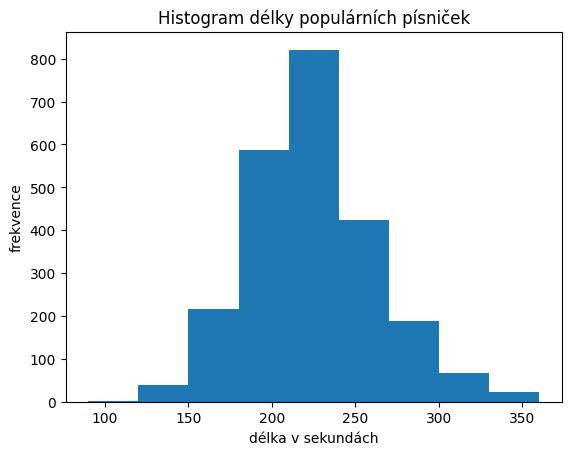

In [96]:
duration = table['duration'] #duration in seconds
fig, main_ax =plt.subplots()
main_ax.set_title('Histogram délky populárních písniček')
main_ax.set_xlabel('délka v sekundách')
main_ax.set_ylabel('frekvence')
plt.hist(duration, bins=[90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
plt.show()


Histogram celkem vypadá dobře. Takže by se ve skutečnosti mohlo jednat o normální rozdělení.

Teď spočteme průměr, rozptyl a směrodatnou odchylku:

In [103]:
duration_mean = duration.mean()
duration_var = duration.var()
duration_std = numpy.std(duration)
print(f"Průměr = {duration_mean}; Rozptyl = {duration_var}; Směrodatná odchylka = {duration_std}")

Průměr = 225.946750524109; Rozptyl = 1868.547918337484; Směrodatná odchylka = 43.21764061226389


Vytvoříme intervaly pro délky a spočteme, počet písniček v každém intervalu. Dále pro každý interval spočteme z-skóre. Z-skóre spočteme jako podíl, kde v čitateli je rozdíl horní hranice intervalu a průměru, a ve jmenovateli je směrodatná odchylka:

Intervaly: <120, <180, <240, <300, <360, >=360

In [114]:
bounds = [120, 180, 240, 300, 360]
number_bounds = [0, 0, 0, 0, 0, 0]
number_bounds[0] = sum(duration < bounds[0])
number_bounds[len(bounds)] = sum(duration >= bounds[len(bounds)-1])
for i in range(1, len(bounds)):
    number_bounds[i] = sum(duration < bounds[i]) - sum(duration < bounds[i-1])
print("Počet písniček v každém intervalu: ", number_bounds)

z_score = [0, 0, 0, 0, 0, 0]
for i in range(0, len(bounds)):
    z_score[i] = (bounds[i]- duration_mean)/duration_std
print("Z-skóre pro každý interval: ", z_score)

Počet písniček v každém intervalu:  [2, 255, 1408, 614, 90, 16]
Z-skóre pro každý interval:  [-2.4514700252758463, -1.0631480542015215, 0.32517391687280345, 1.7134958879471283, 3.101817859021453, 0]


2385

Ze z-skóre spočítáme plochu pod křívkou normální distribuce N(0, 1):

In [115]:
area_under = [0, 0, 0, 0, 0, 0]
for i in range(len(z_score)):
    area_under[i] = stats.norm.cdf(z_score[i])
area_under[len(area_under)-1] = 1
print("Plocha pod křívkou každého intervalu: ", area_under)

Plocha pod křívkou každého intervalu:  [0.007113701783713703, 0.14385740755201204, 0.6274752758867737, 0.9566893253931492, 0.9990383186982759, 1]


Dále spočítáme plochu v rámci jednotlivých intervalů:

In [123]:
area_inside = [0, 0, 0, 0, 0, 0]
area_inside[0] = round(area_under[0], 8)

for i in range(1, len(area_under)):
    x = area_under[i] - area_under[i-1]
    area_inside[i] = round(x, 8)
print("Plocha uvnitř každého intervalu: ", area_inside)


Plocha uvnitř každého intervalu:  [0.0071137, 0.13674371, 0.48361787, 0.32921405, 0.04234899, 0.00096168]


Plochu v rámci intervalů využijeme jako očekávané pravděpodobnosti pro chi-kvadrát test. Jenom pro chi-kvadrát test musíme ještě provést normalizaci dat tak, aby se součty očekavaných dat <em>(ta pravděpodobnost(`area_inside`) krát celkový počet pisníček (`sum_elements`))</em> a pozorovaných dat <em>(`number_bounds`)</em> rovnaly.

In [124]:
sum_elements = sum(number_bounds)

for i in range(len(area_inside)):
    area_inside[i] = area_inside[i] * sum_elements   

stats.chisquare(number_bounds, f_exp=area_inside)

Power_divergenceResult(statistic=205.3276643003221, pvalue=2.058183074578902e-42)

#### Závěr: 
P-hodnota vyšla mnohem menší než 0,05, takže nulovou hypotézu musíme zamitnout a platí alternativní hypotéza: Data nejsou modelovaná normálním rozdělením.

## Alternativní způsoby, jak bychom mohli postupovat.

- __Ještě je možné podívat se na Q-Q plot (quantile - quantile plot)__

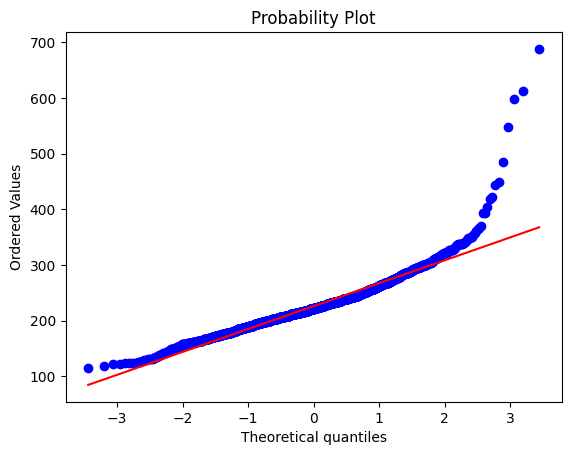

In [125]:
stats.probplot(duration, dist="norm", plot=plt)
plt.show()

#### Závěr: 
Ačkoliv většina bodů je blízko přímce, je dost bodů, které leží daleko od přímky.

- __Shapiro-Wilkův test__

In [126]:
res = stats.shapiro(duration)
print(res)

ShapiroResult(statistic=0.906105101108551, pvalue=5.1749929866740065e-36)


#### Závěr: 
P-hodnota je zase menší než 0,05. Proto nulová hypotéza neplatí.

- **Ten samý qqplot, jenom z knihovny pingouin**

                 W          pval  normal
duration  0.906105  5.174993e-36   False


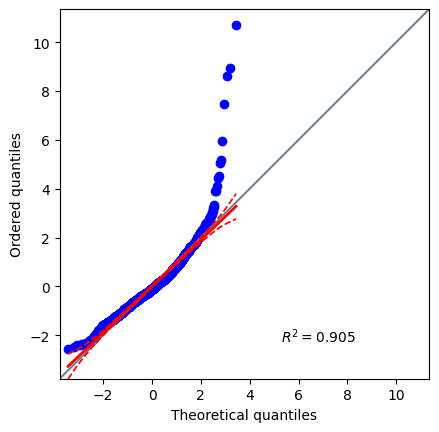

In [128]:
print(pingouin.normality(duration))
ax = pingouin.qqplot(duration, dist='norm')

#### Závěr: 
P-hodnota je znovu menší než 0,05. A ještě k tomu máme proměnnou `normal`, která říká, zda je rozdělení normální.

### 2. Závislost mezi popularitou a speechiness písniček 

Zde budeme zkoumat, zda existuje vztah mezi popularitou písniček a jejich speechiness. Očekáváme, že čím větší je popularita, tím menší je speechiness.<br>
Provedeme lineární regresi. <br>
Nulová hypotéza: mezi popularitou a speechiness není lineární vztah.<br>
Alternativní hypotéza: mezi popularitou a speechiness existuje lineární vztah.


#### Na začátku načteme a přeformujeme data:

In [129]:
popularity = table['popularity']
speechiness = table['speechiness']

x = popularity.values.reshape(-1, 1)
y = speechiness.values.reshape(-1, 1)

Podíváme se, jak data vypadají.

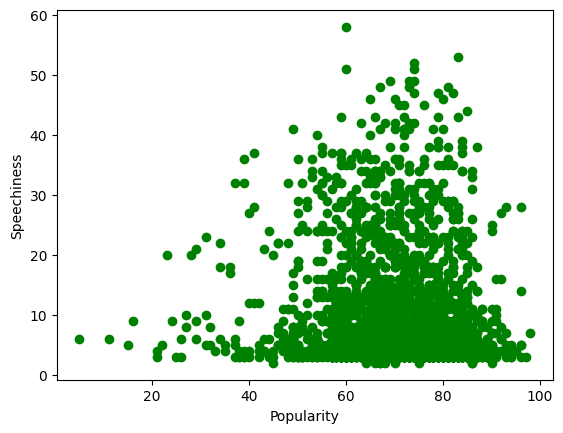

In [134]:
fig, ax = plt.subplots()
ax.set_ylabel('Speechiness')
ax.set_xlabel('Popularity')

plt.scatter(x, y, color="green")
plt.show()

Poté spočítáme průměr  **speechiness** a průměr **popularity**.

In [137]:
speechiness_mean = speechiness.mean()
popularity_mean = popularity.mean()
print(f'Průměr speechiness = {speechiness_mean}, \nPrůměr popularity = {popularity_mean}')

Průměr speechiness = 10.112368972746332, 
Průměr popularity = 70.5266247379455


Pro přímku potřebujeme a a b. Spočíteme je podle [informce z poslední přednašky](https://iuuk.mff.cuni.cz/~samal/vyuka/2223/PSt1/slides-13.pdf):

In [142]:
sum_popularity = 0
a = 0
for i in range(len(speechiness)):
    a += (popularity[i] - popularity_mean)*(speechiness[i] - speechiness_mean)
    sum_popularity  += (popularity[i]-popularity_mean)**2
a = a/sum_popularity
b = speechiness_mean - a*popularity_mean
print("The linear model is: Y = {:.5} + {:.5}*X".format(b, a))

The linear model is: Y = 14.385 + -0.060586*X


Teď vyneseme přímku do grafu:

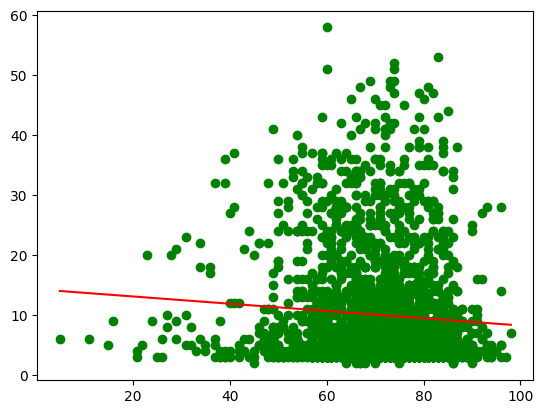

In [144]:
plt.scatter(x, y, color="green")
plt.plot(x, a*x+b, c='red')
plt.show()

Pro to, abychom zjistili p-hodnotu, musíme dostat výsledky regrese následujícím způsobem: uděláme popularitu konstantou a provedeme OLS regresi. Částečně informace byla získána [zde](https://www.statology.org/statsmodels-linear-regression-p-value/).

In [159]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print("P-hodnota je ", est2.pvalues[1])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.65
Date:                Sat, 08 Jul 2023   Prob (F-statistic):           0.000383
Time:                        13:53:57   Log-Likelihood:                -8751.9
No. Observations:                2385   AIC:                         1.751e+04
Df Residuals:                    2383   BIC:                         1.752e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3853      1.217     11.821      0.0

### Závěr:
Jelikož p-hodnota vyšla menší než 0,05, musíme nulovou hypotézu zamitnout a tedy platí, že lineární vztah mezi popularitou a speechiness existuje. A z grafu můžeme vidět, že populárnější jsou ty písničky, které mají nižší speechiness. Informace částečně byla ziskána [zde](https://towardsdatascience.com/the-complete-guide-to-linear-regression-in-python-3d3f8f06bf8).

## Alternativní způsoby, jak bychom mohli postupovat.

- **Můžeme ještě ověřit, jestli jsme správně spočitali přímku pomocí `LinearRegression` funkce z `sklearn.linear_model` knihovny.**<br> Podíváme se, zda máme správně vypočty a nakreslíme dvě přímky: červená - náše vypočty, modrá - z knihovny.

The linear model is: Y = 14.385 + -0.060586X


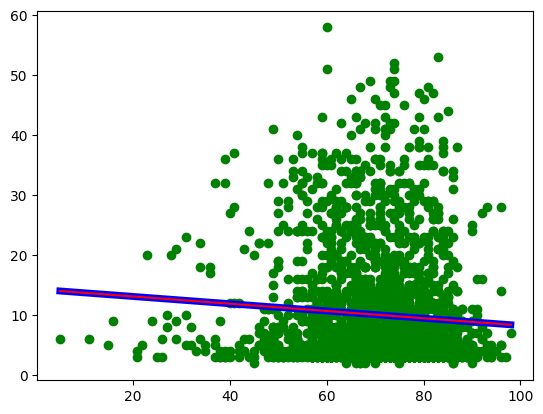

In [148]:
reg = LinearRegression().fit(x, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

predictions = reg.predict(x)
plt.scatter(x, y, color="green")

plt.plot(
    x,
    predictions,
    c='blue',
    linewidth=5
)
plt.plot(x, a*x+b, c='red')
plt.show()

- **Ještě můžeme provést test lineární regrese pomocí knihovny `pingouin`.**

In [149]:
res = pingouin.linear_regression(popularity, speechiness)
print(res)

        names       coef        se          T          pval        r2   
0   Intercept  14.385303  1.216961  11.820674  2.255219e-31  0.005281  \
1  popularity  -0.060586  0.017034  -3.556862  3.826318e-04  0.005281   

     adj_r2   CI[2.5%]  CI[97.5%]  
0  0.004864  11.998891  16.771716  
1  0.004864  -0.093988  -0.027184  


### 3. Závislost mezi popularitou a danceability písniček
Zde budeme zkoumat, zda existuje vztah mezi popularitou písniček a jejich danceability. Očekáváme, že čím větší je popularita, tím větší je danceability.<br>
Provedeme lineární regresi. <br>
Nulová hypotéza: mezi popularitou a danceability není lineární vztah.<br>
Alternativní hypotéza: mezi popularitou a danceability existuje lineární vztah.<br>

Zde nebudeme počítat rovnici přímky ručně použijeme funkci `LinearRegression` z `sklearn.linear_model`:

#### Na začátku načteme a přeformujeme data:

In [162]:
popularity = table['popularity']
dance = table['danceability']

x = popularity.values.reshape(-1, 1)
y = dance.values.reshape(-1, 1)

Vytvoříme model a najdeme rovnici:

The linear model is: Y = 68.686 + -0.023415X


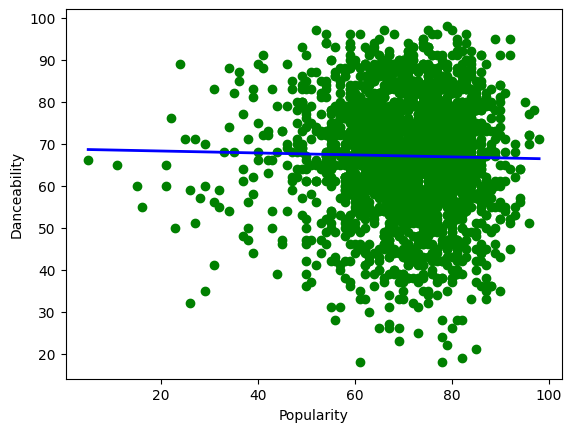

In [163]:
reg = LinearRegression().fit(x, y)

fig, ax = plt.subplots()
ax.set_ylabel('Danceability')
ax.set_xlabel('Popularity')

plt.scatter(x, y, color="green")
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

predictions = reg.predict(x)
plt.plot(
    x,
    predictions,
    c='blue',
    linewidth=2
)
plt.show()


Teď najdeme p-hodnotu stejně jako v předchozím příkladě:

In [164]:
X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
print("P-hodnota je ", est2.pvalues[1])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9056
Date:                Sat, 08 Jul 2023   Prob (F-statistic):              0.341
Time:                        14:12:14   Log-Likelihood:                -9629.0
No. Observations:                2385   AIC:                         1.926e+04
Df Residuals:                    2383   BIC:                         1.927e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.6862      1.758     39.073      0.0

### Závěr:
Jelikož p-hodnota vyšla větší než 0,05, nulovou hypotézu numůžeme zamitnout. Z toho můžeme udělat závěr, že mezi danceability a popularitou není žádný lineatní vztah.

### 4. (bpm) Tempo hudby

Zde budeme zkoumat zda nějak liší střední hodnoty tempa písniček v prvním a ve druhém desetiletí 21. věku.

H0: nelisi se
Alternativni: lisi se

Provedeme dvou vyberovy test. Priprava dat

In [81]:
zeroes = []
tens = []
years = table['year']
bpms = table['bpm']
for i in range(len(years)):
    if years[i] > 2009:
        tens.append(bpms[i])
    else:
        if years[i] > 1999:
            zeroes.append(bpms[i])


result = stats.ttest_ind(zeroes, tens, equal_var=False, alternative='two-sided')
#result.confidence_interval(confidence_level=0.95)
print(result)
#plt.hist(tens)
#plt.show()
res = pingouin.ttest(zeroes, tens)
print(res)

Ttest_indResult(statistic=-0.926464309439658, pvalue=0.3543207988658451)
               T          dof alternative     p-val          CI95%   cohen-d   
T-test -0.926464  1926.210783   two-sided  0.354321  [-3.37, 1.21]  0.039589  \

         BF10     power  
T-test  0.073  0.155471  


Protoze p-value je vetsi nez hladina vyznamnosti, takze prijimame nulovou hypotezu. Z toho lze udelat zaver, ze tempo je celkem stejne pro oba desetileti

### 5 Valence
Valence: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

Zda jsou stredni hodnoty valence pisnocek stejne v prvni pulce nulovych roku a v poslednich letech. Roky pro porovnani 01-05 a 19-23

H0: stejne

Alternativni

In [82]:
before = []
during = []
valence  = table['valence']

for i in range(len(years)):
    if 2000 < years[i] < 2006:
        before.append(valence[i])
    elif 2018 < years[i] < 2024:
        during.append(valence[i])

print(len(before), len(during))

result = stats.ttest_ind(before, during, equal_var=False, alternative='two-sided')

print(result)

res = pingouin.ttest(before, during)
print(res)
print(numpy.mean(during), numpy.mean(before))

492 411
Ttest_indResult(statistic=7.633226890107983, pvalue=5.987604487666038e-14)
               T         dof alternative         p-val         CI95%   
T-test  7.633227  874.607766   two-sided  5.987604e-14  [8.51, 14.4]  \

         cohen-d       BF10  power  
T-test  0.509788  9.332e+10    1.0  
49.17761557177616 60.636178861788615


p-hodnota je mnohem mensi nez, hladina vyznamnosti, takze H0 zamitam a prijimam alternativni hypotezu. Celkove lze rici, ze valence na zacatku nulovych roku byla mensi, nez tedka